# Seizure_Forecasting_RandomForestClassification

This notebook contains feature engineering and model selection

## Data Prep

Use the `database_prep.ipynb` to build table `directory` 

In [81]:
import sys
sys.path.append('..')
from seizurecast.data.file_io import * 
from seizurecast.postgresql import SQLengine
from seizurecast.models.parameters import LABEL_BKG, LABEL_PRE, LABEL_SEZ
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

def setlabel(pres, post, len_pos=300, len_pre=300, sec_gap=600):
    """convert pres and post timestamps to background and preseizure labels"""
    y = []
    for _, (pres, post) in enumerate(zip(pres, post)):
        if post > len_pos and pres > sec_gap + len_pre:
            y.append(LABEL_BKG)
        elif post > len_pos and pres > sec_gap:
            y.append(LABEL_PRE)
        else:
            y.append(LABEL_SEZ)
    return y

In [5]:
# create table tmp_token_group storing Token and their train/test group
pd.read_sql("""
select A.train_test, B.token
from patient_group A
inner join directory B on A.patient=B.patient;
""",SQLengine).to_sql('tmp_token_group', SQLengine, if_exists='replace')

In [6]:
print("Number of Tokens in each group \n", pd.read_sql("select * from tmp_token_group", SQLengine)[['train_test','token']].groupby('train_test').count())

Number of Tokens in each group 
             token
train_test       
test          712
train        2974


## Load train/test dataset

In [10]:
','.join(['*'])

'*'

In [197]:
def load_dataset(feature_table, token_table, len_pos, len_pre, sec_gap, limit=100, SQLengine=SQLengine):
    """
    Args:
        feature_table: feature table name
        token_table: token_table that contains train_test label
        len_pos: post seizure length in second
        len_pre: pre seizure length in second
        sec_gap: gap in second between pre-seizrue and seizure
        limit: limit of items
    """
    dataset={}
    columns = ['*']
    for i, group in enumerate(['train', 'test']):
        dataset[group] = (pd.read_sql(f"""
        (
            select {','.join(columns)}
            from {feature_table} A
            where A.token in (
              select B.token from {token_table} B where B.train_test='{group}'
            ) and (
              A.pres<{sec_gap + len_pre}
              and {sec_gap}<A.pres
              and A.post>{len_pos}
            ) 
            limit {limit}
        )

        union

        (
            select {','.join(columns)}
            from {feature_table} A
            where A.token in (
              select B.token from {token_table} B where B.train_test='{group}' 
            ) and (
              {sec_gap + len_pre}<A.pres
              and A.post>{len_pos}
            )
            limit {limit}
        );
        """, SQLengine))
    return dataset

dataset = load_dataset('features', 'tmp_token_group', 300, 300, 600, limit=100000)
print(f"Size of Tran set = {dataset['train'].shape}; \nSize of Test set = {dataset['test'].shape}")

Size of Tran set = (103878, 196); 
Size of Test set = (100495, 196)


Patient numbers in the train test

In [198]:
dirs = pd.read_sql("select token, patient from directory", SQLengine)
print("number of patients in train/test")
pd.concat(dataset)\
    .loc[:,['token']]\
    .drop_duplicates()\
    .reset_index()\
    .merge(dirs, how='left')\
    .set_index(['level_0','level_1'])\
    .groupby('level_0')['patient'].nunique()

number of patients in train/test


level_0
test     23
train    56
Name: patient, dtype: int64

Histogram of patients and their representation in the dataset


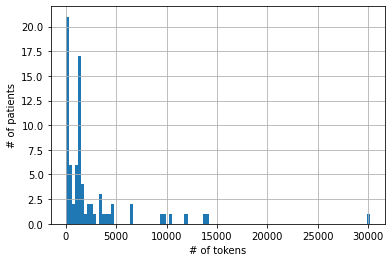

In [199]:
print("Histogram of patients and their representation in the dataset")
patient_count = pd.concat(dataset)\
    .drop_duplicates()\
    .reset_index()\
    .merge(dirs, how='left')\
    .set_index(['level_0','patient'])\
    .loc[:,'f0']\
    .groupby(['level_0', 'patient']).count()
_ = patient_count.hist(bins=100)
_=plt.xlabel("# of tokens")
_=plt.ylabel("# of patients")

## Balance Data

I balance data using subsampling, weighted by the number of samples each patient has, i.e., the more samples a patient has in the dataset, the less likely each sample will be selected.   

Before balance 
                 index
level_0 label        
test    bckg   100000
        pres      495
train   bckg   100000
        pres     3878


After balance 
                   index  patient
train_test label                
test       bckg     495      495
           pres     495      495
train      bckg    3878     3878
           pres    3878     3878


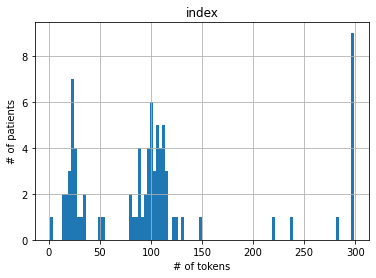

In [206]:
print(
    'Before balance \n',
    pd.concat(dataset)
        .reset_index()
        .set_index(['level_0'])
        .assign(label = lambda x: setlabel(x.pres, x.post, len_pos=300, len_pre=300, sec_gap=600))
        .loc[:,['label','index']]
        .groupby(['level_0','label'])
        .count()
)

def balance_df(df):
    """Credit=https://stackoverflow.com/a/45839920/13653455"""
    g = df.groupby(['train_test','label'])
    return g.apply(lambda x: x.sample(g.size().min(), weights=1/x['count']).reset_index(drop=True)).drop(['token','label'],axis=1)

ds_balanced = pd.concat([
        pd.concat(dataset, names=['train_test'])
        .query(f"train_test == '{g}'")
        .assign(label = lambda x: setlabel(x.pres, x.post, len_pos=300, len_pre=300, sec_gap=600))
        .reset_index()
        .merge(dirs, how='left')
        .merge(patient_count.reset_index(name="count").loc[:,['patient', 'count']], how='left')
        .set_index(['train_test', 'level_1'])
        .pipe(balance_df)

        for g in ['train', 'test']
    ])

print("\n")
print(
    "After balance \n",
    
    ds_balanced
        .loc[:,['index', 'patient']]
        .groupby(['train_test', 'label'])
        .count()
)
_=(
    ds_balanced
        .loc[:,['index', 'patient']]
        .groupby(['train_test', 'label', 'patient'])
        .count().hist(bins=100)
)
_=plt.xlabel("# of tokens")
_=plt.ylabel("# of patients")

We have balanced data both label-wise and patient-wise

In [221]:
print("Number of patients participating in the train/test set")
(
    ds_balanced
    .loc[:,['patient']]
    .drop_duplicates()
    .groupby(['train_test', 'label'])
    .count()
)

Number of patients participating in the train/test set


patient
train_test label         
test       bckg        21
           pres         2
train      bckg        38
           pres        18

## Drop missing values

In [256]:
print(f"There are {ds_balanced.isnull().values.sum()} of Null values (NaN)")
print("Dropping rows")
ds_balanced = ds_balanced.dropna()

There are 8 of Null values (NaN)
Dropping rows


## convert to numpy for sckit learn

In [257]:
X = ds_balanced.reset_index().iloc[:,4:196].to_numpy()
y = ds_balanced.reset_index().iloc[:,1].to_numpy()
print(f"Shape \t X \t\t y \n  \t{X.shape} \t{y.shape}")

Shape 	 X 		 y 
  	(8744, 192) 	(8744,)


# Sklearn

## Train-test Split

In [258]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression


In [259]:
# Binarize the label
y_b = preprocessing.label_binarize(y, classes=[LABEL_BKG, LABEL_PRE])
y_b = np.reshape(y_b, (len(y_b),))

# Train test split
train_X, test_X, train_y, test_y = train_test_split(X, y_b,
    test_size=0.2,
    random_state=41)

np.shape(train_X), test_X.shape, train_y.shape, test_y.shape

((6995, 192), (1749, 192), (6995,), (1749,))

## Scale

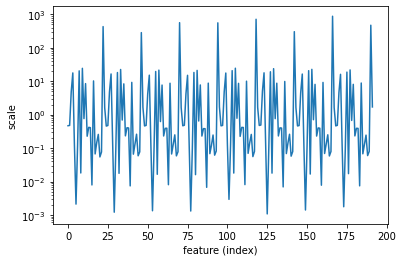

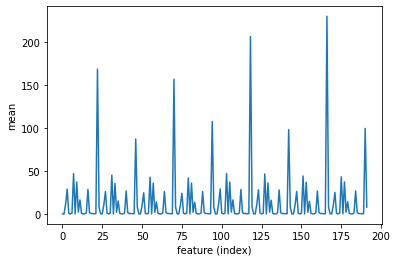

In [275]:
scaler = preprocessing.StandardScaler().fit(train_X)
_=plt.plot(scaler.scale_)
_=plt.yscale('log')
_=plt.ylabel('scale')
_=plt.xlabel('feature (index)')
_=plt.figure()
_=plt.plot(scaler.mean_)
_=plt.ylabel('mean')
_=plt.xlabel('feature (index)')

# Model Selection

## Cross validation

Linear Discriminat Analysis has been applied to EEG 
https://link.springer.com/chapter/10.1007/978-3-319-08422-0_42

In [282]:
clf = {}

# Linear Model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf['lda'] = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
print(
    "LinearDiscriminantAnalysis", 
    cross_val_score(clf['lda'], train_X, train_y, cv=5)
)

LinearDiscriminantAnalysis [0.60400286 0.57183703 0.6147248  0.60757684 0.60686204]


Logistic Regression is a conventional linear classifier 

In [431]:
clf['lg'] = LogisticRegression(random_state=0, max_iter=2000)
print(
    "LogisticRegression", 
    cross_val_score(clf['lg'], scaler.transform(train_X), train_y, cv=5)
)

LogisticRegression [0.63902788 0.59328091 0.64045747 0.61829878 0.61401001]


Random forest classifier is a conventional non-linear classifier

In [458]:
from sklearn.ensemble import RandomForestClassifier
clf['rf'] = RandomForestClassifier(n_estimators=200, max_depth=None,
    min_samples_split=3, random_state=0)
print(
    "RandomForestClassifier", 
    cross_val_score(clf['rf'], train_X, train_y, cv=5)
)

RandomForestClassifier [0.79413867 0.78270193 0.78984989 0.78127234 0.768406  ]


In [429]:
from sklearn.ensemble import AdaBoostClassifier
clf['adb'] = AdaBoostClassifier(n_estimators=100, random_state=0)
cross_val_score(clf['adb'], scaler.transform(train_X), train_y, cv=5)

array([0.68406004, 0.68548964, 0.70693352, 0.68334525, 0.6919228 ])

Multilayer perceptron. NN based non linear classifier

In [286]:
from sklearn.neural_network import MLPClassifier
clf['mlp'] = MLPClassifier(solver='lbfgs', alpha=1e0, hidden_layer_sizes=(10, 5), max_iter=10000, random_state=1)
cross_val_score(clf['mlp'], scaler.transform(train_X), train_y, cv=5)

/Users/yanxlin/opt/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


array([0.61186562, 0.59328091, 0.58470336, 0.61758399, 0.60686204])

In [37]:
# # Export the clf for evaluation
# with open('tmp/model.pkl', 'wb') as fp:
#     pickle.dump((clf, X, y), fp)

# Keras

In [420]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['font.size'] = 14

In [376]:
"""Set seed"""
def set_seed():
    import tensorflow as tf
    import random as rn
    import os
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(1)
    rn.seed(1)

In [449]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

set_seed()

def make_model():
    np.random.seed(0)
    layer = 0
    
    model = Sequential()
    model.add(Input(shape=(192,)))
    
    layer += 1
    model.add(Dense(5, activation='relu', kernel_regularizer='l1', name=f'Layer-{layer}'))
    layer += 1
    model.add(Dense(2, activation='relu', kernel_regularizer='l1', name=f'Layer-{layer}'))
    layer += 1
    model.add(Dense(1, activation='relu', kernel_regularizer='l1', name=f'Layer-{layer}'))
    
    return model

clf['nn'] = make_model()
clf['nn'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(clf['nn'].summary())

print('start training')
history = clf['nn'].fit(
        scaler.transform(train_X), 
        train_y,
        validation_split=0.2, 
        batch_size=50, 
        epochs=200,
        verbose=0,
        shuffle=False
#         callbacks=EarlyStopping(monitor='val_loss', mode='min')
)

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer-1 (Dense)              (None, 5)                 965       
_________________________________________________________________
Layer-2 (Dense)              (None, 2)                 12        
_________________________________________________________________
Layer-3 (Dense)              (None, 1)                 3         
Total params: 980
Trainable params: 980
Non-trainable params: 0
_________________________________________________________________
None
start training


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


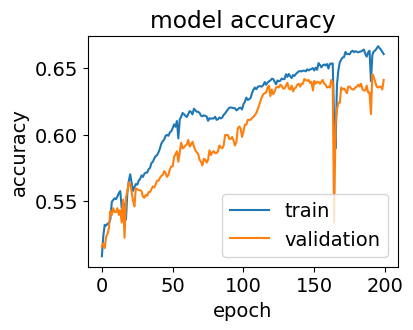

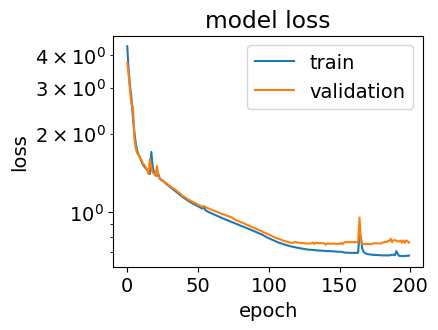

In [450]:
def plot_history(history):
    """Credit=https://stackoverflow.com/q/41908379/13653455"""
    print(history.history.keys())
    #  "Accuracy"
    plt.figure(figsize=[4,3])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    # "Loss"
    plt.figure(figsize=[4,3])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
plot_history(history)

# Evaluation

In [459]:
clf['rf'].fit(test_X, test_y)
clf['lda'].fit(test_X, test_y)
clf['mlp'].fit(scaler.transform(test_X), test_y)
clf['adb'].fit(test_X, test_y)
clf['lg'].fit(scaler.transform(test_X), test_y)

LogisticRegression(max_iter=2000, random_state=0)

## Confusion Matrix

In [442]:
import numpy as np
import itertools
from seizurecast.plots import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize=(4, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=14)
#     plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)

Confusion matrix, without normalization
[[893   0]
 [  0 856]]


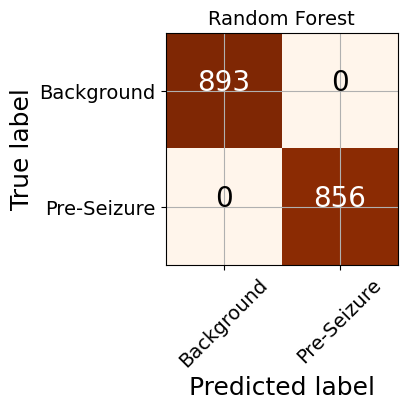

In [460]:
pred_y = {
    'rf': clf['rf'].predict(test_X),
    'nn': model.predict(scaler.transform(test_X))
}
# Confusion matrix
plot_confusion_matrix(confusion_matrix(test_y, pred_y['rf']), classes = ['Background', 'Pre-Seizure'],
                      title = 'Random Forest')

## ROC Curve

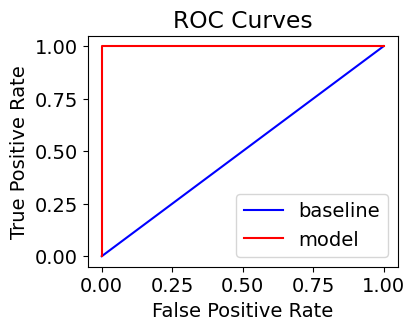

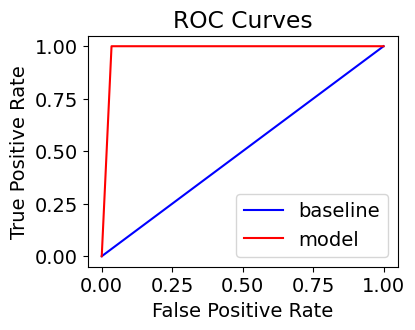

In [463]:
def plot_roc_curve(base_fpr, base_tpr, model_fpr, model_tpr):
    # Plot formatting
    plt.figure(figsize=(4, 3))

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label='baseline')
    plt.plot(model_fpr, model_tpr, 'r', label='model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('ROC Curves');
    plt.show();
    
roc = {}
roc['rf'] = roc_curve(test_y, clf['rf'].predict_proba(test_X)[:, 1])

roc['nn'] = roc_curve(test_y, pred_y['nn'])

plot_roc_curve([0, 1], [0, 1], roc['rf'][0], roc['rf'][1])
plot_roc_curve([0, 1], [0, 1], roc['nn'][0], roc['nn'][1])


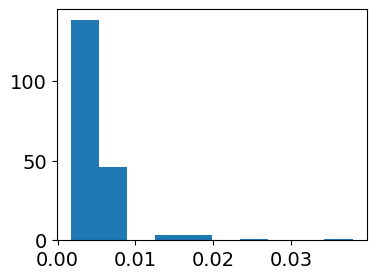

In [462]:
def plot_feature_importance(forest):
    import matplotlib.pyplot as plt
    import numpy as np
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    num_of_features = len(indices)
    # Plot the impurity-based feature importances of the forest
    plt.figure(figsize=[5/15*num_of_features, 3])
    plt.title("Feature importances")
    plt.bar(range(len(importances)), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(len(importances)), indices)
    plt.xlim([-1, len(importances)])
#     plt.xlim([-1, 10])
    # plt.show()
    return(indices)

# indices = plot_feature_importance(clf['rf'])
plt.figure(figsize=[4,3])
_=plt.hist(clf['rf'].feature_importances_)


# save model and dataset

In [467]:
import pickle
# with open('../models/fea192-scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# clf['nn'].save('../models/fea192-KerasNN')

# with open('../data/processed/fea192-Xy.pkl', 'wb') as f:
#     pickle.dump([X, y], f)

In [287]:
# import pickle
# with open('../models/model.pkl', 'rb') as fp:
#     clf = pickle.load(fp)

# # load dataset
# import pickle
# with open('../tmp/ds10min.pkl', 'rb') as fp:
#     dataset, labels = pickle.load(fp)
# np.shape(dataset)

In [22]:
# import numpy as np
# import sys
# sys.path.append('..')
# from seizurecast.models.par import LABEL_PRE, LABEL_BKG
# ds, y = dataset, labels
# id_pre = np.array([yi for yi in range(0, len(y)) if any([y[yi] == lbl for lbl in [LABEL_PRE]])])
# id_bkg = np.array([yi for yi in range(0, len(y)) if any([y[yi] == lbl for lbl in [LABEL_BKG]])])
# eval_X_pre = [ds[i] for i in np.random.choice(id_pre, size=100)]
# eval_X_bkg = [ds[i] for i in np.random.choice(id_bkg, size=100)]
# ds = []
# for i in range(0, len(eval_X_pre)+len(eval_X_bkg)-2):
#     if i//50%2 == 0:
#         ds.extend(np.transpose(eval_X_bkg.pop()))
#     else:
#         ds.extend(np.transpose(eval_X_pre.pop()))
   

(-1, 8)

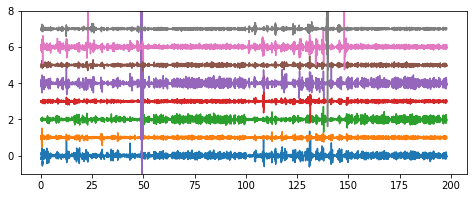

In [34]:
# datplot = np.transpose(ds)
# x = np.arange(0, datplot.shape[1]) / 256
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 3))
# for i in range(datplot.shape[0]):
#     yi = datplot[i]/(np.max(datplot[i])-np.min(datplot[i]))
#     yi = datplot[i] / 150
#     plt.plot(x, yi+i)
# plt.ylim([-1, 8])

In [14]:
         
# with open('../data/processed/svdemo-5bkg-5pre-5bkg-5pre.txt', 'wb') as fp:
#     # Must be saved as nchannel x nsample
#     np.savetxt(fp, np.transpose(ds), delimiter=',')

In [41]:
# np.shape(X), np.shape(y)

((1572427, 16), (1572427,))

### Test if the saved raw data can be used to evaluate

In [87]:
# import dataset_funcs
# x = dataset_funcs.bin_power_freq([np.loadtxt('./data/svdemo-3bkg-3pre-3bkg-3pre.txt', delimiter=',')], 256)
# clf.predict(x)

AttributeError: module 'dataset_funcs' has no attribute 'bin_power_freq'